In [1]:
import tensorflow as tf
import numpy as np
import math
import os
#from sklearn.model_selection import train_test_split


#compression
import pickle
import bz2

#timing
import time

#plotting
import matplotlib.pyplot as plt

In [2]:
    in_file = bz2.BZ2File("/Users/lukelorenz/Desktop/ECGNN/data/sim_ecg_data.bz2",'rb')
    data = pickle.load(in_file)
    in_file.close()
    
    in_file = bz2.BZ2File("/Users/lukelorenz/Desktop/ECGNN/data/sim_ecg_labels.bz2",'rb')
    labels = pickle.load(in_file)
    in_file.close()

In [3]:
def get_runtime(func):
    """Decorator to get the various runtimes of different functions

        Runs specified input function and times execution time
    """
    def time_func(*args,**kwargs):
        start = time.time()
        res = func(*args, **kwargs)
        end = time.time()
        print(f"The function {func.__name__} took {end-start} seconds to run")
        return res
    return time_func

In [4]:
class Model:
    """Create a Residual Neural Network with outputs into dense layers

    Validation set validates our model performance during training,
    reducing problems such as overfitting


    May get the warning message:
        'This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use
        the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
        To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags'

        Which is not an error, just saying can take advantange of other CPU optimizations

    Parameters
    ----------
    train_x : numpy.ndarray
        Training ECG data
    train_y : numpy.ndarray
        Training ECG labels
    test_x : numpy.ndarray
        Testing ECG data
    test_y : numpy.ndarray
        Testing ECG labels

    Returns
    -------
    Sequential
        A ResNet model

    """

    def __init__(self, train_X, train_y, test_X, test_y):

        #compiled network
        self.compiled = self.compile()
        #self.tb = TensorBoard(log_dir = "logs/{}".format(time.time()))

        self.train_X = train_X
        self.train_y = train_y


        #taking 50% of testing for a split of 70 training 15 validation 15 testing
        self.validation_X = test_X[( (len(test_X)//2) ):]
        self.test_X = test_X[:( (len(test_X)//2) )]

        self.validation_y = test_y[( (len(test_y)//2) ):]
        self.test_y = test_y[:( (len(test_y)//2) )]

    def residual_block(self,X, num_filter, kernel_size, down_sample=False):
        """
        Residual block implemented in compile funct.
        
        """
        X_shortcut = X

        if down_sample == False:
            X = tf.keras.layers.Conv1D(filters=num_filter, kernel_size=kernel_size, strides=1, padding='same')(X)
        else:
            X = tf.keras.layers.Conv1D(filters=num_filter, kernel_size=kernel_size, strides=2, padding='same')(X)
            X_shortcut = tf.keras.layers.Conv1D(filters=num_filter, kernel_size=1, strides=2, padding='same')(X_shortcut)
            X_shortcut = tf.keras.layers.BatchNormalization(axis=2)(X_shortcut)

        X = tf.keras.layers.BatchNormalization(axis=2)(X)
        X = tf.keras.layers.ReLU()(X)

        X = tf.keras.layers.Conv1D(filters=num_filter, kernel_size=kernel_size, strides=1, padding='same')(X)
        X = tf.keras.layers.BatchNormalization(axis=2)(X)

        X = tf.keras.layers.Add()([X, X_shortcut])
        X = tf.keras.layers.ReLU()(X)

        return X

    def compile(self):
        """
        Resnet-18 model,

        """

        input_layer = tf.keras.Input(shape=(2500,12))
        # Conv1
        x = tf.keras.layers.Conv1D(filters=64, kernel_size=7, strides=2, padding='same')(input_layer)
        # Conv2_x
        x = tf.keras.layers.MaxPooling1D(pool_size =3, strides =2, padding ='same')(x)
        x = self.residual_block(x, num_filter=64, kernel_size=3, down_sample=False)
        x = self.residual_block(x, num_filter=64, kernel_size=3, down_sample=False)
        # Conv3_x
        x = self.residual_block(x, num_filter=128, kernel_size=3, down_sample=True)
        x = self.residual_block(x, num_filter=128, kernel_size=3, down_sample=False)
        # Conv4_x
        x = self.residual_block(x, num_filter=256, kernel_size=3, down_sample=True)
        x = self.residual_block(x, num_filter=256, kernel_size=3, down_sample=False)
        # Conv5_x
        x = self.residual_block(x, num_filter=512, kernel_size=3, down_sample=True)
        x = self.residual_block(x, num_filter=512, kernel_size=3, down_sample=False)
        # Classifier
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)

        model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
        print(model.summary())

        #compile
        model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
              tf.keras.metrics.AUC()]
        )

        #tf.keras.utils.vis_utils.plot_model(model, show_shapes=True, show_layer_names=True)

        return model



class Train:

    """Trains our fully connected Neural Network

    Parameters:
    ----------
    model : Sequential
        A NN model, compiled as specified by the Model class above

    Stores:
    -------
    self.compliled : Sequential
        compiled CNN model containing build specified in Model class
    self.trained_model :
        Trained CNN fit on training data

    """

    def __init__(self,model):
        self.model = model
        self.compiled = model.compiled
        self.trained_model, self.model_history = self.train_model(self.compiled, self.model)

    @get_runtime #prints runtime to train the model
    def train_model(self, compiled, model):
        """Returns a compiled (trained) model
        """

        #training the model on training data
        #starting with 20 epochs, if still improving performance will increase
        model_history = compiled.fit(
        x = model.train_X,
        y = model.train_y,
        epochs = 25,
        validation_data = (model.validation_X, model.validation_y)
        #,callbacks = [model.tb]
        )

        return compiled, model_history

    def save_model(self):

        self.compiled.save("simulation_model")

        pass

In [5]:
def splitExamples(data,labels,split_factor):
    """Splits data and labels into separate training / testing arrays

        Parameters:
        -----------
        data : np array
            ECG waveform data
        labels : np array
            labels associated with an example
        split_factor : float range (0-1)
            What proportion of examples will be training (0.8 = 80%)

        Returns:
        --------
        train_X : numpy.ndarray
            training examples
        train_y: numpy.ndarray
            training labels
        test_X: numpy.ndarray
            testing examples
        test_y: numpy.ndarray
            testing labels
    """

    #going to split 70/30 for now (70 train, 15 val, 15 test)

    #splitting training data
    trainx = data[:int(len(data)*split_factor)]
    trainy = labels[:int(len(labels)*split_factor)]

    #splitting testing data
    testx = data[int(len(data)*split_factor):]
    testy = labels[int(len(labels)*split_factor):]

    return trainx, trainy, testx, testy

In [6]:
print(data.shape)
reshaped = np.transpose(data, axes=[0, 2, 1]) #switching data
print(reshaped.shape)

print(f"example 1 label: {labels[:15]}")

x_train, y_train, x_test, y_test = splitExamples(reshaped,labels,0.8)

(12000, 12, 2500)
(12000, 2500, 12)
example 1 label: [1 1 1 1 1 1 1 0 0 1 0 1 1 0 0]


In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(9600, 2500, 12)
(9600,)
(2400, 2500, 12)
(2400,)


In [8]:
compiled_model = Model(x_train, y_train, x_test, y_test)

2022-12-06 19:25:25.115270: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 19:25:25.143444: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2500, 12)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1250, 64)     5440        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 625, 64)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 625, 64)      12352       max_pooling1d[0][0]              
______________________________________________________________________________________________

In [9]:
trained_model = Train(compiled_model)

Train on 9600 samples, validate on 1200 samples
Epoch 1/25
9600/9600 [==============================] - 1442s 150ms/sample - loss: 0.7033 - binary_accuracy: 0.5921 - auc: 0.5873 - val_loss: 0.6333 - val_binary_accuracy: 0.6475 - val_auc: 0.6804
Epoch 2/25
9600/9600 [==============================] - 1539s 160ms/sample - loss: 0.6549 - binary_accuracy: 0.6197 - auc: 0.6370 - val_loss: 0.6487 - val_binary_accuracy: 0.6225 - val_auc: 0.6839
Epoch 3/25
9600/9600 [==============================] - 1555s 162ms/sample - loss: 0.6485 - binary_accuracy: 0.6250 - auc: 0.6520 - val_loss: 0.6610 - val_binary_accuracy: 0.6583 - val_auc: 0.7089
Epoch 4/25
9600/9600 [==============================] - 6537s 681ms/sample - loss: 0.6394 - binary_accuracy: 0.6406 - auc: 0.6677 - val_loss: 0.6756 - val_binary_accuracy: 0.6200 - val_auc: 0.7206
Epoch 5/25
9600/9600 [==============================] - 1499s 156ms/sample - loss: 0.6395 - binary_accuracy: 0.6383 - auc: 0.6725 - val_loss: 0.9979 - val_binary_ac

In [10]:
loss, accuracy, auc = trained_model.trained_model.evaluate(x_test,y_test)
print(f"Loss : {loss}")
print(f"Binary Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")

2400/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Loss : 0.6760002827644348
Binary Accuracy : 0.6508333086967468
Area under the Curve (ROC) : 0.7385293245315552


In [11]:
def plot_history_metrics(history: tf.keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

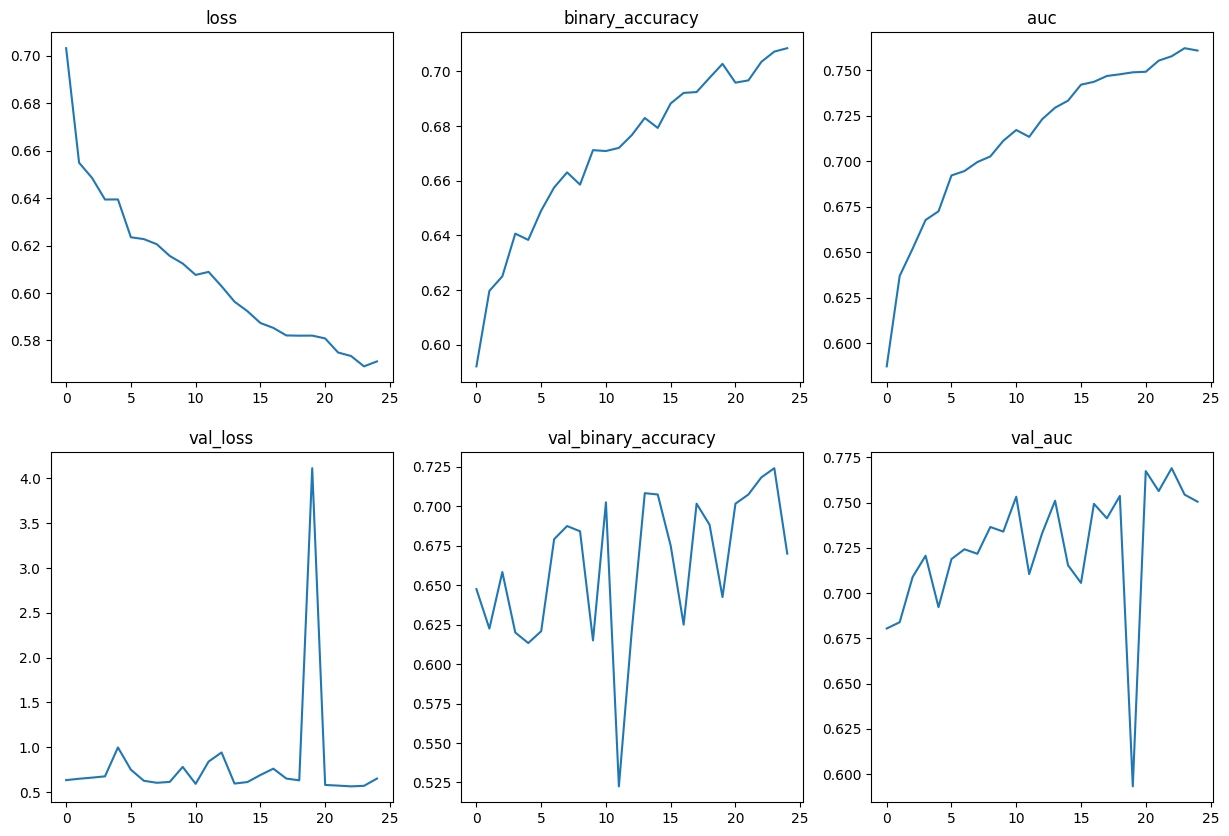

In [12]:
plot_history_metrics(trained_model.model_history)

In [13]:
from sklearn.metrics import confusion_matrix
y_pred = (trained_model.trained_model.predict(x_test)>=0.5).astype(int)
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[1310   90]
 [ 748  252]]


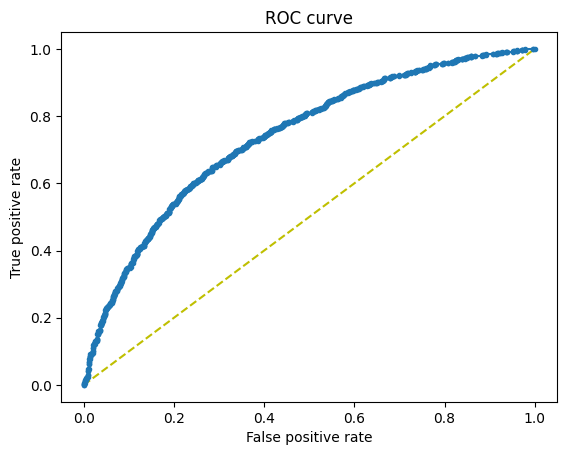

In [14]:
from sklearn.metrics import roc_curve

y_preds = trained_model.trained_model.predict(x_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test,y_preds)
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr,tpr,marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()